In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
#from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score
import pickle


In [137]:
df=pd.read_csv('../data/raw/XGBoost_train.csv')
df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


# train_test_split 

In [138]:
target=df.loc[:,'Machine failure']
features=df.drop('Machine failure' , axis=1)

features_train, features_test, target_train, target_test= train_test_split(features , target,                                                          
                                                                            random_state = 42,
                                                                            test_size = 0.2 )
features_train_copy=features_train.copy()

print('Shape of features_train:',features_train.shape)
print('Shape of target_train:',target_train.shape)
print('Shape of features_test:',features_test.shape)
print('Shape of features_test:',target_test.shape)

features_test.to_csv('features_test.csv', index=False)

Shape of features_train: (109143, 13)
Shape of target_train: (109143,)
Shape of features_test: (27286, 13)
Shape of features_test: (27286,)


In [76]:
features_train.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
12407,12407,L53889,L,301.5,310.7,1481,43.7,77,0,0,0,0,0
85011,85011,L50140,L,300.7,309.5,1452,43.4,85,0,0,0,0,0
65292,65292,M24687,M,298.5,309.1,1365,57.0,27,0,0,0,0,0
18478,18478,L50785,L,301.6,310.7,1543,31.9,16,0,0,0,0,0
100267,100267,L49210,L,298.9,308.6,1633,32.9,124,0,0,0,0,0


In [27]:
# changing features name that could be process for models

In [139]:
def rename_columns(df):
    """changing features name that could be process for models"""
    df.rename(columns={
        'Air temperature [K]': "Air_temperature",
        'Process temperature [K]': "Process_temperature",
        "Rotational speed [rpm]": "Rotational_speed",
        "Torque [Nm]": "Torque",
        "Tool wear [min]": "Tool_wear",
        "Product ID" : "Product_ID"
        
    }, inplace=True)

# Assuming features_train and features_test are your DataFrames
rename_columns(features_train)
rename_columns(features_test)


In [140]:
features_train.head()

,id,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,TWF,HDF,PWF,OSF,RNF
12407,12407,L53889,L,301.5,310.7,1481,43.7,77,0,0,0,0,0
85011,85011,L50140,L,300.7,309.5,1452,43.4,85,0,0,0,0,0
65292,65292,M24687,M,298.5,309.1,1365,57.0,27,0,0,0,0,0
18478,18478,L50785,L,301.6,310.7,1543,31.9,16,0,0,0,0,0
100267,100267,L49210,L,298.9,308.6,1633,32.9,124,0,0,0,0,0


# Data imputation 

In [39]:
features_train.isna().sum()

id                     0
Product ID             0
Type                   0
Air_temperature        0
Process_temperature    0
Rotational_speed       0
Torque                 0
Tool_wear              0
TWF                    0
HDF                    0
PWF                    0
OSF                    0
RNF                    0
dtype: int64

# baseline model 

In [52]:
# define num_cols and cat_cols
num_cols=['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque',
          'Tool_wear', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
cat_col=["Type"]

features_train_base=features_train.loc[:,num_cols+cat_col]
features_test_base=features_test.loc[:,num_cols+cat_col]

type_mapping = {'L': 0, 'M': 1, 'H': 2}

features_train_base['Type_numeric'] = features_train_base['Type'].map(type_mapping)
features_test_base['Type_numeric'] = features_test_base['Type'].map(type_mapping)

features_train_base=features_train_base.drop("Type" , axis=1)
features_test_base=features_test_base.drop("Type" , axis=1)

f1_scor: 0.8575096277278563
recall_score: 0.7625570776255708
precison_score: 0.9794721407624634


<Axes: >

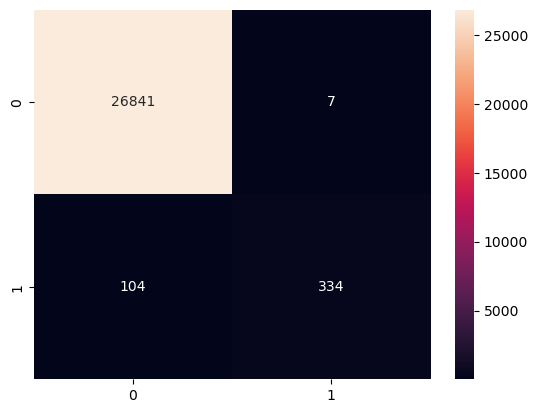

In [53]:


#### Random Forest

model_rf_base=RandomForestClassifier(n_estimators=50 , class_weight='balanced' , random_state=42)
model_rf_base.fit(features_train_base , target_train)

# predict and evaluate on test set
target_test_pred_base_rf=model_rf_base.predict(features_test_base)

print('f1_scor:',f1_score(target_test, target_test_pred_base_rf))
print('recall_score:',recall_score(target_test, target_test_pred_base_rf))
print('precison_score:',precision_score(target_test, target_test_pred_base_rf))

confusion_matrix_rf_base = confusion_matrix(target_test, target_test_pred_base_rf)

sns.heatmap(confusion_matrix_rf_base, annot=True, fmt='d')

f1_scor: 0.5879396984924623
recall_score: 0.8013698630136986
precison_score: 0.4642857142857143
roc_auc_score: 0.8931424702434405


<Axes: >

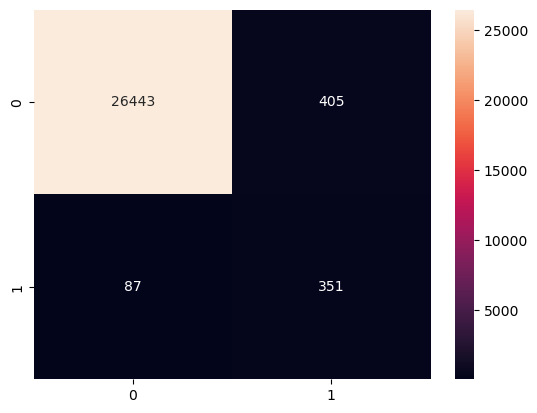

In [55]:
## logistic regression
model_log_base=LogisticRegression(class_weight='balanced' , random_state=42 , max_iter=10000)
pipeline_log_base=Pipeline([('std' , MinMaxScaler() ), ('model' ,model_log_base)])

pipeline_log_base.fit(features_train_base , target_train)

# predict and evaluate on test set  
target_test_pred_base=pipeline_log_base.predict(features_test_base)

print('f1_scor:',f1_score(target_test, target_test_pred_base))
print('recall_score:',recall_score(target_test, target_test_pred_base))
print('precison_score:',precision_score(target_test, target_test_pred_base))
print('roc_auc_score:',roc_auc_score(target_test, target_test_pred_base))

confusion_matrix_log_base = confusion_matrix(target_test, target_test_pred_base)
sns.heatmap(confusion_matrix_log_base, annot=True, fmt='d')

In [191]:
df["Product ID"].nunique()

9976

# Feature engineering

<Axes: ylabel='Numeric_ID'>

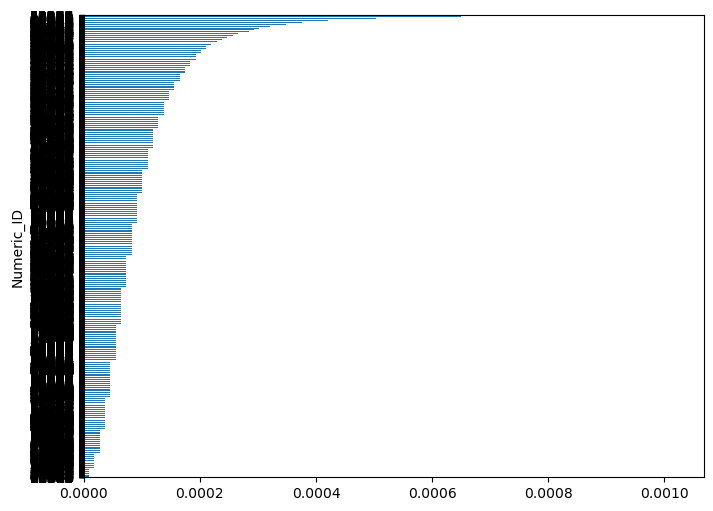

In [65]:
features_train_copy['Numeric_ID'] = features_train_copy['Product ID'].str.extract('(\d+)')

ratios = pd.crosstab(index=features_train_copy["Numeric_ID"], 
                         columns='ratio', normalize='columns').sort_values(by='ratio')    
fig, ax = plt.subplots(1, figsize=(8, 6))
ratios.plot(kind='barh', legend=False, ax=ax)

In [141]:
def preprocess_features(features, var=None):
    
    # creating new feature
    features['power'] =features['Rotational_speed'] * (2 * np.pi / 60) * features['Torque']

    # label encoder for type
    type_mapping = {'L': 0, 'M': 1, 'H': 2}
    features['Type_numeric'] = features['Type'].map(type_mapping)

    # extracting digits from Product_ID
    features['Numeric_ID'] = features['Product_ID'].str.extract('(\d+)')
    features.loc[:, "Numeric_ID"] = features.loc[:, "Numeric_ID"].astype(str)

    if var is None:
        # Calculate normalized cross-tabulation only for the training set
        var = pd.crosstab(index=features["Numeric_ID"], columns='ratio',
                          normalize='columns').sort_values(by='ratio', ascending=False)

    # Replace categories beyond the top 10 with 'other'
    features.loc[~features["Numeric_ID"].isin(var.index[:10]), "Numeric_ID"] = 'other'

    return features, var

In [142]:
# Process the training set and get the calculated 'var_train'
features_train, var_train = preprocess_features(features_train)

# Use the calculated 'var_train' to process the test set
features_test, _ = preprocess_features(features_test, var_train)


In [143]:
print(features_train["Numeric_ID"].unique())
print(features_test["Numeric_ID"].unique())

['other' '48892' '49056' '53140' '53257' '54275' '53271' '48894' '53270'
 '53258' '48897']
['53271' 'other' '53258' '48894' '48892' '54275' '53257' '53270' '48897'
 '49056' '53140']


In [144]:
print(features_train.shape)
print(features_test.shape)

(109143, 16)
(27286, 16)


In [145]:
# onehot encod
import pdpipe as pdp

onehot = pdp.OneHotEncode(['Numeric_ID'], drop_first=False)
features_train = onehot.fit_transform(features_train)
features_test = onehot.transform(features_test)

print(features_train.shape)
print(features_test.shape)



(109143, 26)
(27286, 26)


In [146]:
features_train_copy=features_train.copy()
col_correlated= ['Air_temperature', 'Process_temperature']
pca=PCA(n_components=0.90)
pipe_std_pca=Pipeline([('std' , StandardScaler()),('pca' , pca)])
pipe_std_pca.fit(features_train_copy.loc[:,col_correlated])
print('\033[1mas we know these features are highly correlated and we can apply dimensionality reduction\033[0m')
print('\033[1mas from this method for 0.90 of variance we get 2 components\033[0m')
print('n_components:',pca.n_components_)

as we know these features are highly correlated and we can apply dimensionality reduction
as from this method for 0.90 of variance we get 2 components
n_components: 1


In [147]:
### Applying pca
col_correlated= ['Air_temperature', 'Process_temperature']

drop_col=["Product_ID" , "Type"  ,"id"]

keep_col = [col for col in features_train.columns if col not in col_correlated and col not in drop_col]

pipe_std_pca=Pipeline([('std' , StandardScaler()),('pca' , PCA(n_components=0.9))])

col_dropper=ColumnTransformer([('pass_throu' , 'passthrough' , keep_col)] , remainder='drop')
corr_transformer=ColumnTransformer([('pipe_std_pca' , pipe_std_pca ,col_correlated )] , remainder=col_dropper)
col_names=['pca_0']+keep_col
features_train = pd.DataFrame(corr_transformer.fit_transform(features_train) , columns=col_names)
features_test = pd.DataFrame(corr_transformer.transform(features_test) , columns=col_names)
print(features_train.shape)
print(features_test.shape)

(109143, 22)
(27286, 22)


# Model training

In [149]:
# RandomForestClassifier

gridsearch_results_RandomForestClassifier:
rf_best_estimator_: RandomForestClassifier(class_weight='balanced', max_depth=50, n_estimators=50,
                       random_state=42)
rf_best_score_: 0.8546342761207602


F1_rf:  0.8615384615384616
Precision_rf:  0.9824561403508771
Recall_rf:  0.7671232876712328


<Axes: >

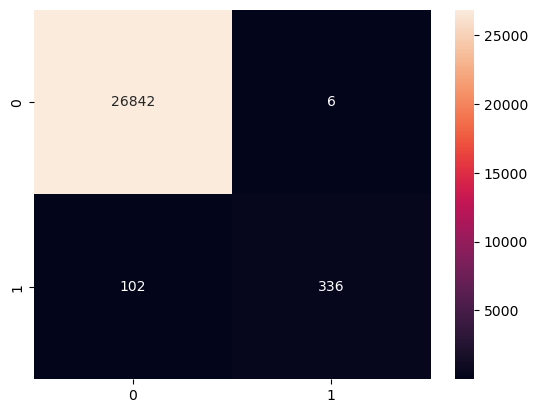

In [148]:
model_rf=RandomForestClassifier(n_estimators=50 , class_weight='balanced' , random_state=42)
search_space_rf = {'max_depth': np.geomspace(start=3, stop=50, num=10, dtype='int'),
'min_samples_leaf': np.geomspace(start=1, stop=500, num=10, dtype='int')}

model_rf_optimized=GridSearchCV(estimator=model_rf , param_grid=search_space_rf , cv=5 , scoring='f1' , n_jobs=-1)

model_rf_optimized.fit(features_train , target_train)

target_test_pred_optimized_rf=model_rf_optimized.predict(features_test)

print('gridsearch_results_RandomForestClassifier:')
print('rf_best_estimator_:',model_rf_optimized.best_estimator_)
print('rf_best_score_:',model_rf_optimized.best_score_)
print('\n')
print('F1_rf: ', f1_score(target_test, target_test_pred_optimized_rf))
print('Precision_rf: ', precision_score(target_test, target_test_pred_optimized_rf))
print('Recall_rf: ', recall_score(target_test, target_test_pred_optimized_rf))
confusion_matrix_rf_optimized= confusion_matrix(target_test, target_test_pred_optimized_rf)
sns.heatmap(confusion_matrix_rf_optimized, annot=True, fmt='d')

In [159]:
# to improve the performance

In [151]:

features_train=features_train.drop("Torque" , axis=1)
features_test=features_test.drop("Torque" , axis=1)

In [181]:
## RandomForestClassifier

gridsearch_results_RandomForestClassifier:
rf_best_estimator_: RandomForestClassifier(class_weight='balanced', max_depth=26, n_estimators=50,
                       random_state=42)
rf_best_score_: 0.8563669885835179


F1_rf:  0.8641025641025641
Precision_rf:  0.9853801169590644
Recall_rf:  0.769406392694064


<Axes: >

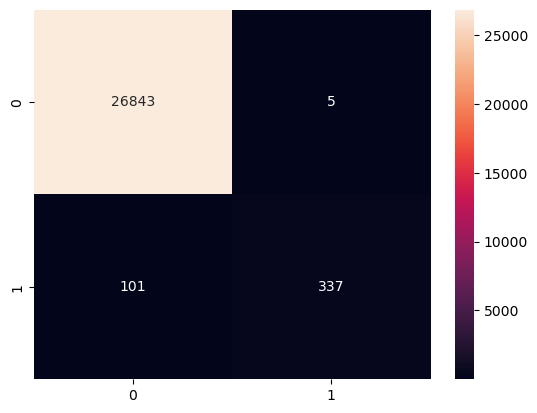

In [152]:
model_rf=RandomForestClassifier(n_estimators=50 , class_weight='balanced' , random_state=42)
search_space_rf = {'max_depth': np.geomspace(start=3, stop=50, num=10, dtype='int'),
'min_samples_leaf': np.geomspace(start=1, stop=500, num=10, dtype='int')}

model_rf_optimized=GridSearchCV(estimator=model_rf , param_grid=search_space_rf , cv=5 , scoring='f1' , n_jobs=-1)

model_rf_optimized.fit(features_train , target_train)

target_test_pred_optimized_rf=model_rf_optimized.predict(features_test)

print('gridsearch_results_RandomForestClassifier:')
print('rf_best_estimator_:',model_rf_optimized.best_estimator_)
print('rf_best_score_:',model_rf_optimized.best_score_)
print('\n')
print('F1_rf: ', f1_score(target_test, target_test_pred_optimized_rf))
print('Precision_rf: ', precision_score(target_test, target_test_pred_optimized_rf))
print('Recall_rf: ', recall_score(target_test, target_test_pred_optimized_rf))
confusion_matrix_rf_optimized= confusion_matrix(target_test, target_test_pred_optimized_rf)
sns.heatmap(confusion_matrix_rf_optimized, annot=True, fmt='d')

In [182]:
## DecisionTreeClassifier

gridsearch_results_RandomForestClassifier:
rf_best_estimator_: DecisionTreeClassifier(class_weight='balanced', max_depth=36, random_state=42)
rf_best_score_: 0.760233208688695


F1_rf:  0.755656108597285
Precision_rf:  0.7488789237668162
Recall_rf:  0.7625570776255708


<Axes: >

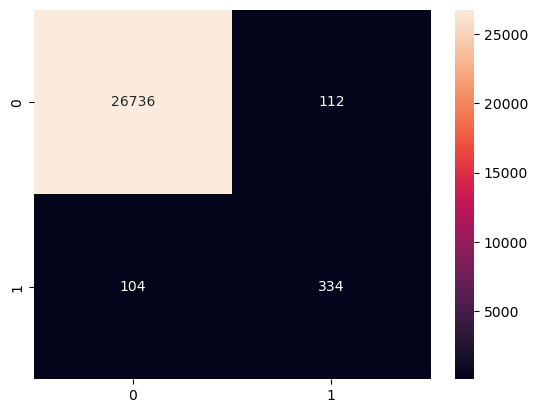

In [174]:
model_tree = DecisionTreeClassifier(random_state = 42, class_weight = 'balanced')

search_space_rf = {'max_depth': np.geomspace(start=3, stop=50, num=10, dtype='int'),
'min_samples_leaf': np.geomspace(start=1, stop=500, num=10, dtype='int')}

model_DT_optimized=GridSearchCV(estimator=model_tree , param_grid=search_space_rf , cv=5 , scoring='f1' , n_jobs=-1)

model_DT_optimized.fit(features_train , target_train)

target_test_pred_optimized_DT=model_DT_optimized.predict(features_test)

print('gridsearch_results_RandomForestClassifier:')
print('rf_best_estimator_:',model_DT_optimized.best_estimator_)
print('rf_best_score_:',model_DT_optimized.best_score_)
print('\n')
print('F1_rf: ', f1_score(target_test, target_test_pred_optimized_DT))
print('Precision_rf: ', precision_score(target_test, target_test_pred_optimized_DT))
print('Recall_rf: ', recall_score(target_test, target_test_pred_optimized_DT))
confusion_matrix_rf_optimized= confusion_matrix(target_test, target_test_pred_optimized_DT)
sns.heatmap(confusion_matrix_rf_optimized, annot=True, fmt='d')

In [183]:
## LogisticRegression

Average of f1_scor for cross_val_score: 0.7230875313798941 [0.72375691 0.72625698 0.77235772 0.710013   0.68305304]
f1_scor_train: 0.723014804845222
f1_scor: 0.7003089598352213
recall_score: 0.776255707762557
precison_score: 0.6378986866791745
roc_auc_score: 0.8845335451804441


<Axes: >

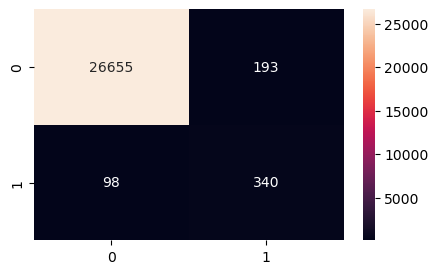

In [175]:
model_log_base=LogisticRegression(class_weight='balanced' , random_state=42 , max_iter=10000)
pipeline_log_base=Pipeline([('std' , MinMaxScaler() ), ('model' ,model_log_base)])
pipeline_log_base.fit(features_train , target_train)

result_log_unoptimized=cross_val_score(estimator=pipeline_log_base , X=features_train , y=target_train,
                                       cv=5 , scoring='f1')
print('Average of f1_scor for cross_val_score:',result_log_unoptimized.mean() , result_log_unoptimized)

# predict and evaluate on test set
target_test_pred_base=pipeline_log_base.predict(features_test)

target_train_pred_base=pipeline_log_base.predict(features_train)
print('f1_scor_train:',f1_score(target_train, target_train_pred_base))


print('f1_scor:',f1_score(target_test, target_test_pred_base))
print('recall_score:',recall_score(target_test, target_test_pred_base))
print('precison_score:',precision_score(target_test, target_test_pred_base))
print('roc_auc_score:',roc_auc_score(target_test, target_test_pred_base))
confusion_matrix_log_base = confusion_matrix(target_test, target_test_pred_base)
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix_log_base, annot=True, fmt='d')

In [184]:
## LinearSVC

gridsearch_results_LinearSVC:
log_best_estimator_: Pipeline(steps=[('std', MinMaxScaler()),
                ('svc',
                 LinearSVC(C=0.01, class_weight='balanced', dual=False,
                           random_state=42))])
log_best_score_: 0.8325520944314629


F1_log:  0.8314883148831489
Precision_log:  0.9013333333333333
Recall_log:  0.771689497716895
roc_ouc:  0.8851556844961114


<Axes: >

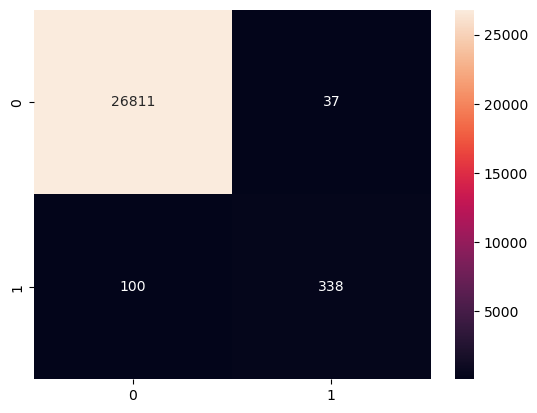

In [176]:
## algorithm : LinearSVC
# tune hyperparameters
svc = LinearSVC(dual=False, class_weight='balanced', random_state=42)
#svc=SVC(random_state=42)
pipeline_svc=Pipeline([('std' , MinMaxScaler()) ,('svc' , svc)])

search_space={'svc__C':[0.01 ,0.1 ,1 ,10 ,100] } # 'kernel':['linear' , 'poly' ,'rbf']

model_svm=GridSearchCV(estimator=pipeline_svc , param_grid=search_space , cv=5 , n_jobs=-1, scoring='f1')
model_svm.fit(features_train , target_train)
target_test_pred_optimized_svc=model_svm.predict(features_test)
print('gridsearch_results_LinearSVC:')
print('log_best_estimator_:',model_svm.best_estimator_)
print('log_best_score_:',model_svm.best_score_)
print('\n')
print('F1_log: ', f1_score(target_test, target_test_pred_optimized_svc))
print('Precision_log: ', precision_score(target_test, target_test_pred_optimized_svc))
print('Recall_log: ', recall_score(target_test, target_test_pred_optimized_svc))
print('roc_ouc: ', roc_auc_score(target_test, target_test_pred_optimized_svc))
confusion_matrix_svc_optimized= confusion_matrix(target_test, target_test_pred_optimized_svc)
sns.heatmap(confusion_matrix_svc_optimized, annot=True, fmt='d')

In [185]:
##  KNeighborsClassifier

F1_log:  0.8560311284046692
Precision_log:  0.990990990990991
Recall_log:  0.7534246575342466
roc_ouc:  0.8766564586836906


<Axes: >

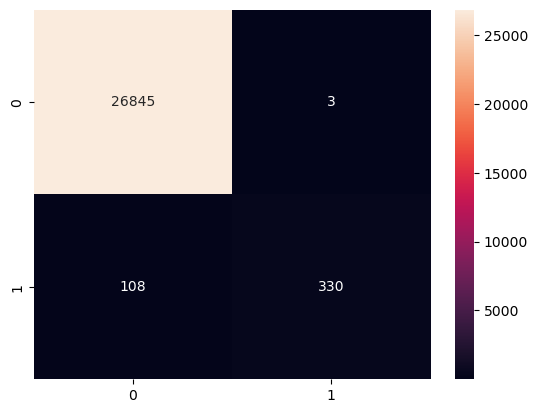

In [178]:
#### build model
## algorithm : KNeighborsClassifier
pipeline_knn=Pipeline([('std' , StandardScaler()),('knn' , KNeighborsClassifier())])
pipeline_knn.fit(features_train , target_train)
# predict and evaluate on test set
target_test_pred_knn=pipeline_knn.predict(features_test)
print('F1_log: ', f1_score(target_test, target_test_pred_knn))
print('Precision_log: ', precision_score(target_test, target_test_pred_knn))
print('Recall_log: ', recall_score(target_test, target_test_pred_knn))
print('roc_ouc: ', roc_auc_score(target_test, target_test_pred_knn))
confusion_matrix_knn= confusion_matrix(target_test, target_test_pred_knn)
sns.heatmap(confusion_matrix_knn, annot=True, fmt='d')

# Model training XGboost

In [154]:
for col in features_train.columns:
    features_train[col] = pd.to_numeric(features_train[col], errors='coerce')        
    features_test[col] = pd.to_numeric(features_test[col], errors='coerce')


Accuracy 0.9961885215861614
F1_log:  0.867007672634271
Precision_log:  0.9854651162790697
Recall_log:  0.773972602739726
roc_ouc:  0.8868931845641419


<Axes: >

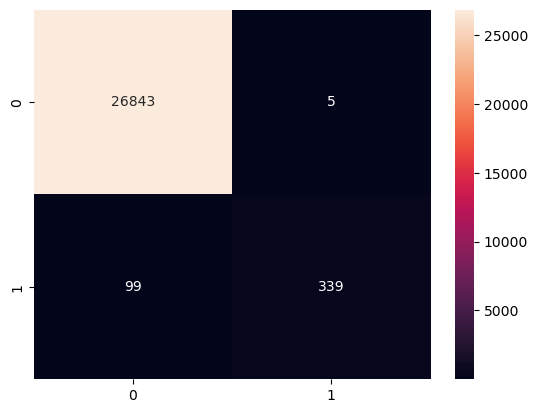

In [180]:
from xgboost import XGBClassifier

# Instantiate XGBClassifier
model_XGB= XGBClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
model_XGB.fit(features_train, target_train)

# Make predictions on the test set
predictions_XGB = model_XGB.predict(features_test)

# Evaluate accuracy
print("Accuracy",accuracy_score(target_test, predictions_XGB))
print('F1_log: ', f1_score(target_test, predictions_XGB))
print('Precision_log: ', precision_score(target_test, predictions_XGB))
print('Recall_log: ', recall_score(target_test, predictions_XGB))
print('roc_ouc: ', roc_auc_score(target_test, predictions_XGB))
confusion_matrix_svc_optimized= confusion_matrix(target_test, predictions_XGB)
sns.heatmap(confusion_matrix_svc_optimized, annot=True, fmt='d')

Best Hyperparameters: {'max_depth': 3, 'n_estimators': 50}
Accuracy 0.9961518727552591
F1_log:  0.865211810012837
Precision_log:  0.9882697947214076
Recall_log:  0.769406392694064
roc_ouc:  0.8846287029024551


<Axes: >

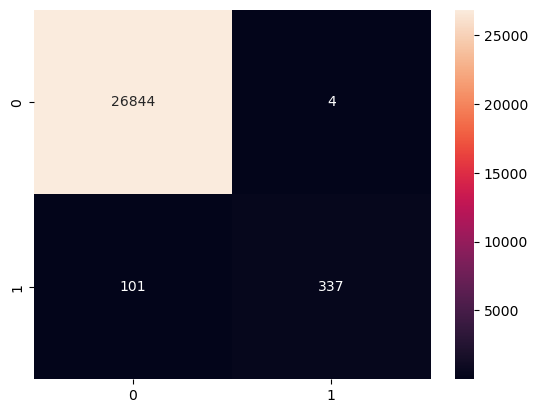

In [171]:
# Assuming 'features_train' and 'target_train' are your training features and target
# Create an XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Define the F1 scorer
f1_scorer = make_scorer(f1_score)

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [3, 7 ,25],
    # Add more hyperparameters as needed
}

# Initialize GridSearchCV with the F1 scorer
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=f1_scorer, cv=5)

# Perform grid search on the training data
grid_search.fit(features_train, target_train)

# Get the best hyperparameters from grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions_XGB = best_model.predict(features_test)


# Evaluate accuracy
print("Accuracy",accuracy_score(target_test, predictions_XGB))
print('F1_log: ', f1_score(target_test, predictions_XGB))
print('Precision_log: ', precision_score(target_test, predictions_XGB))
print('Recall_log: ', recall_score(target_test, predictions_XGB))
print('roc_ouc: ', roc_auc_score(target_test, predictions_XGB))
confusion_matrix_svc_optimized= confusion_matrix(target_test, predictions_XGB)
sns.heatmap(confusion_matrix_svc_optimized, annot=True, fmt='d')


# Model Interpretation

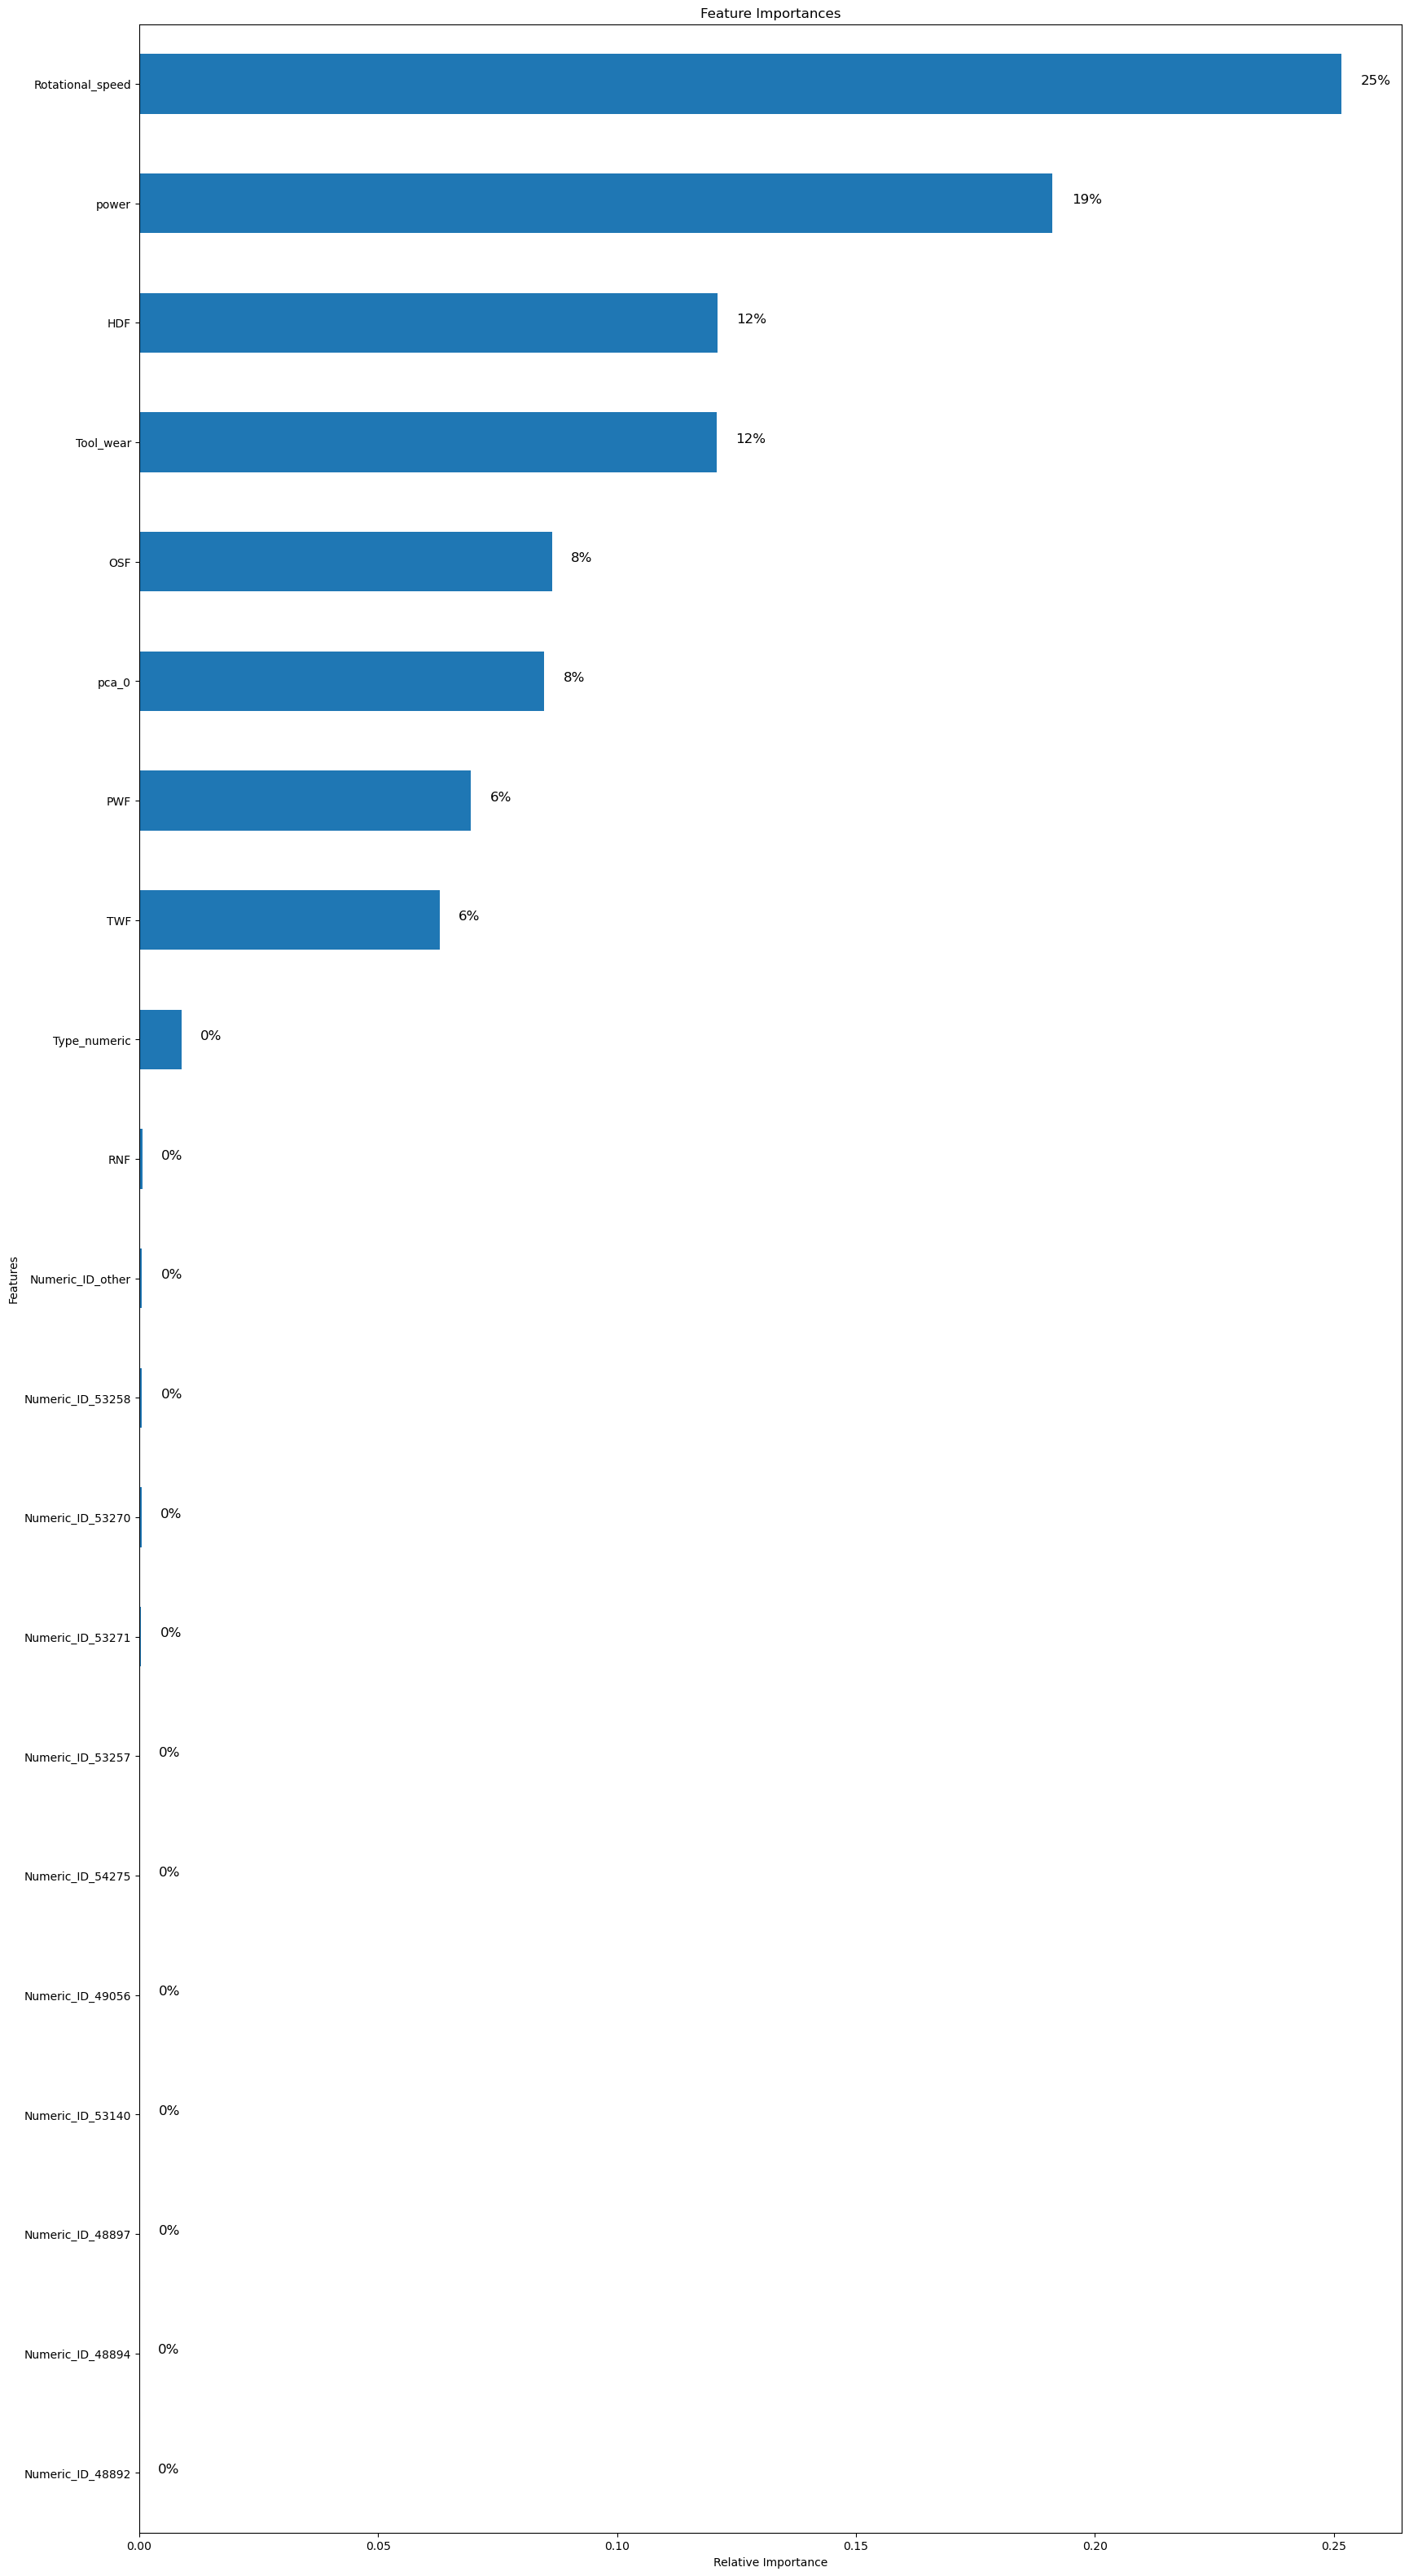

In [195]:
fig, ax = plt.subplots(figsize=(20, 40))

# Compute feature importances and sort them
feature_importance = pd.Series((model_rf_optimized.best_estimator_).feature_importances_,
                               index=features_train.columns).sort_values()

# Plotting horizontal bar chart for feature importances
feature_importance.plot(kind='barh', ax=ax, title='Feature Importances')
ax.set_xlabel('Relative Importance')
ax.set_ylabel('Features')

# Adding text annotations for importance percentages
for idx in range(len(feature_importance.index)):
    ax.text(s='{}%'.format(int(100 * feature_importance.iloc[idx])),
            x=feature_importance.iloc[idx] + 0.004,
            y=idx,
            size=12,
            color='black')


# Prediction 

In [197]:
df_prediction=pd.read_csv('../data/raw/XGBoost_test.csv')
df_prediction.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [198]:
rename_columns(df_prediction)
df_prediction, _ = preprocess_features(df_prediction, var_train)
df_prediction = onehot.transform(df_prediction)
df_prediction = pd.DataFrame(corr_transformer.transform(df_prediction) , columns=col_names)
df_prediction = df_prediction.drop("Torque" , axis=1)
for col in features_train.columns:
    df_prediction[col] = pd.to_numeric(df_prediction[col], errors='coerce')        
df_prediction

,pca_0,Rotational_speed,Tool_wear,TWF,HDF,PWF,OSF,RNF,power,Type_numeric,...,Numeric_ID_48894,Numeric_ID_48897,Numeric_ID_49056,Numeric_ID_53140,Numeric_ID_53257,Numeric_ID_53258,Numeric_ID_53270,Numeric_ID_53271,Numeric_ID_54275,Numeric_ID_other
0,-1.720377,1499.0,60.0,0.0,0.0,0.0,0.0,0.0,5965.046691,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.237157,1713.0,17.0,0.0,0.0,0.0,0.0,0.0,5166.286287,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.778900,1525.0,96.0,0.0,0.0,0.0,0.0,0.0,6020.600521,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.085456,1479.0,5.0,0.0,0.0,0.0,0.0,0.0,7372.312648,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-2.546731,1515.0,114.0,0.0,0.0,0.0,0.0,0.0,6552.262718,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90949,-1.669336,1484.0,15.0,0.0,0.0,0.0,0.0,0.0,6278.326311,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
90950,0.819418,1542.0,31.0,0.0,0.0,0.0,0.0,0.0,5457.951749,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
90951,3.530958,1501.0,187.0,0.0,0.0,0.0,0.0,0.0,6507.432191,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
90952,1.764243,1534.0,69.0,0.0,0.0,0.0,0.0,0.0,6473.796205,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [199]:
y_pred=model_XGB.predict(df_prediction)
display(pd.crosstab(y_pred, columns = 'count'))

col_0,count
row_0,
0,89814
1,1140
